# Generate a Parametric Noise Model

We will use pairs of noisy observations $x_i$ and clean signal $s_i$ (created by averaging many noisy images) to estimate the conditional distribution $p(x_i|s_i)$ by fitting a Gaussian Mixture Model.

**Bootstrap Mode**: The clean signal is generated by running Noise2Void in the notebooks ```01_N2VTraining.ipynb``` and ```02_N2VPrediction.ipynb``` and denoising the images of interest, directly. 

**Calibration Mode**: The clean signal is generated by averaging static, calibration images. 

In [1]:
import torch
dtype = torch.float
device = torch.device("cuda:0") 
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch.distributions import normal
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../')
import pn2v.gaussianMixtureNoiseModel
import pn2v.utils
import pn2v.histNoiseModel
from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel
from pn2v import gaussianMixtureNoiseModel

### Download data

Download the data from  https://owncloud.mpi-cbg.de/index.php/s/224xGSeHquMbQYu. The link contains three different datasets (Convallaria, mouse skull nuclei and mouse actin). Here we show the pipeline for Convallaria dataset. Load the appropriate dataset from the right path. 

The noise model is a characteristic of your camera. The downloaded data folder contains a set of calibration images (For the Mouse skull nuceli dataset, it is ```edgeoftheslide_300offset.tif``` and the data to be denoised is named ```example2_digital_offset300.tif```). We can either fit a GMM with noisy-GT pairs from data and calibration images or we can bootstrap a suitable GMM noise model after denoising the noisy images with Noise2Void and then use these denoised images as pseudo GT or signal for the purpose of estimation of the noise model.

### Specify ```path```,```dataName```,  ```n_gaussian```, ```n_coeff``` and ```use_calibration```
Ensure that ```dataName``` is set same as in ```01_N2VTraining.ipynb```

In [2]:
path="../../data/Mouse skull nuclei/"
dataName = 'mouseskullnuclei' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.
mode='bootstrap' # Either `bootstrap` or `calibration`

In [3]:
if mode =='bootstrap': # Bootstrapping mode 
    nameN2VModel = dataName+'_n2v'
    observation= imread(path+'example2_digital_offset300.tif') #Load the appropriate data
    net=torch.load(path+"/last_"+nameN2VModel+".net")
else: 
    nameN2VModel= None
    observation= imread(path+'edgeoftheslide_300offset.tif') # Load the appropriate data

nameNoiseModel = path+'trained_weights_minSignal_maxSignal_GMM_'+dataName+'_'+str(n_gaussian)+'gaussian_'+str(n_coeff)+'coefficients_'+mode

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
if mode=='bootstrap':
    # This cell is only run if bootstrap mode is selected. This performs N2V denoising for generating pseudoGT.
    results=[]
    meanRes=[]
    resultImgs=[]
    inputImgs=[]
    dataTest = observation

    for index in range(dataTest.shape[0]):

        im=dataTest[index]
        # We are using tiling to fit the image into memory
        # If you get an error try a smaller patch size (ps)
        means = prediction.tiledPredict(im, net, ps=256, overlap=48,
                                                device=device, noiseModel=None)
        resultImgs.append(means)
        inputImgs.append(im)
        print ("image:", index)

image: 0
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
image: 7
image: 8
image: 9
image: 10
image: 11
image: 12
image: 13
image: 14
image: 15
image: 16
image: 17
image: 18
image: 19
image: 20
image: 21
image: 22
image: 23
image: 24
image: 25
image: 26
image: 27
image: 28
image: 29
image: 30
image: 31
image: 32
image: 33
image: 34
image: 35
image: 36
image: 37
image: 38
image: 39
image: 40
image: 41
image: 42
image: 43
image: 44
image: 45
image: 46
image: 47
image: 48
image: 49
image: 50
image: 51
image: 52
image: 53
image: 54
image: 55
image: 56
image: 57
image: 58
image: 59
image: 60
image: 61
image: 62
image: 63
image: 64
image: 65
image: 66
image: 67
image: 68
image: 69
image: 70
image: 71
image: 72
image: 73
image: 74
image: 75
image: 76
image: 77
image: 78
image: 79
image: 80
image: 81
image: 82
image: 83
image: 84
image: 85
image: 86
image: 87
image: 88
image: 89
image: 90
image: 91
image: 92
image: 93
image: 94
image: 95
image: 96
image: 97
image: 98
image: 99
image: 100

(200, 512, 512)


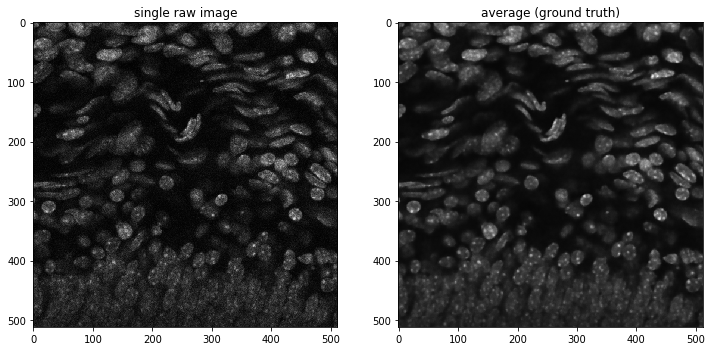

In [5]:
# The data contains 100 images of a static sample.
# In case using calibration data mode, we estimate the clean signal by averaging all images.
# In bootstrap mode, we estimate pseudo GT by using N2V denoised images.
if mode=='bootstrap':
    signal = np.array(resultImgs)   
else:
    signal=np.mean(observation,axis=0)[np.newaxis,...]

# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='average (ground truth)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

Let us first take a look at the distribution of signals $s_i$ that are present in this data.
While most pixels are background, we comfortably cover a range to values of 30000 and below. The signals in the images we want to denoise should be within this range.

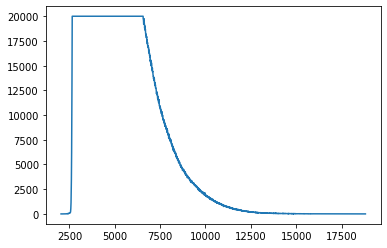

In [7]:
checkSignalHist = np.histogram(signal, bins=2560)
plt.plot( checkSignalHist[1][:-1], np.clip(checkSignalHist[0],0,20000))

### Creating the noise model
Using the raw pixels $x_i$, and our averaged GT (in case of calibration data) or pseudo ground truth (in case of bootstrapping) $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [8]:
if mode=='bootstrap':
    lb = np.percentile(signal,0.5)
    ub = np.percentile(signal, 99.5)
    stepsize=observation[0].size
    n_images=observation.shape[0]
    sig_obs_pairs= np.zeros((n_images*stepsize,2))
    for i in range(n_images):
        sig_obs_pairs[stepsize*i:stepsize*(i+1),0] = signal[i].ravel()
        sig_obs_pairs[stepsize*i:stepsize*(i+1),1] = observation[i].ravel()
    sig_obs_pairs = sig_obs_pairs[ (sig_obs_pairs[:,0]>lb) & (sig_obs_pairs[:,0]<ub)]
else:
    stepsize=observation[0].size
    n_images=observation.shape[0]
    sig_obs_pairs= np.zeros((n_images*stepsize,2))
    for i in range(n_images):
        j = i//n_images
        sig_obs_pairs[stepsize*i:stepsize*(i+1),0] = signal[j].ravel()
        sig_obs_pairs[stepsize*i:stepsize*(i+1),1] = observation[i].ravel()
    
    
sig_obs_pairs= pn2v.utils.fastShuffle(sig_obs_pairs, 2)

In [9]:
min_signal=np.min(sig_obs_pairs[:, 0])
max_signal=np.max(sig_obs_pairs[:, 0])
print(min_signal)
print(max_signal)

2687.080322265625
10298.533203125


In [10]:
gaussianMixtureNoiseModel = pn2v.gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal, max_signal, weight=None, n_gaussian = n_gaussian, n_coeff = n_coeff)
gaussianMixtureNoiseModel.train(sig_obs_pairs, batchSize = 250000, n_epochs = 4000, learning_rate=0.1, name = nameNoiseModel)

0 18.991504669189453
100 7.536449432373047
200 7.524939060211182
300 7.522718906402588
400 7.524232864379883
500 7.529514312744141
600 7.526686191558838
700 7.524600982666016
800 7.520073413848877
900 7.525343894958496
1000 7.522296905517578
1100 7.524703025817871
1200 7.523281097412109
1300 7.523421764373779
1400 7.523698806762695
1500 7.523991107940674
1600 7.526697158813477
1700 7.528324604034424
1800 7.523182392120361
1900 7.525771141052246
2000 7.524850845336914
2100 7.525827884674072
2200 7.524118900299072
2300 7.52345609664917
2400 7.525992393493652
2500 7.524837017059326
2600 7.523980140686035
2700 7.52537727355957
2800 7.523917198181152
2900 7.52324104309082
3000 7.524746894836426
3100 7.528686046600342
3200 7.525529861450195
3300 7.524515151977539
3400 7.522683143615723
3500 7.5225300788879395
3600 7.524670600891113
3700 7.525036811828613
3800 7.5263519287109375
3900 7.524559020996094


## Visualize noise model for a specific *signal-bin* 

Below we just visualize our GMM based noise model for any given signal. In addition, we also visualize how our GMM model fits to the true noise model which we create using all calibraton data in the form of histogram

In [11]:
minVal, maxVal =2000, 22000 # set according to min and max values present in data to be denoised, it is irrelevant for learning GMM. Just for visualization
bins = 400
histogramFD = pn2v.histNoiseModel.createHistogram(bins, minVal, maxVal, observation, signal)
hist_noiseModel = histogramFD[0]

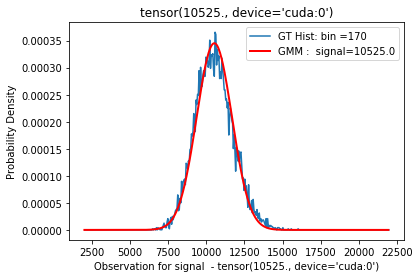

In [12]:
n_bin = 400
index= 170
min_signal=2000
max_signal=22000
binclip=500
histBinSize=(max_signal-min_signal)/n_bin

querySignal= (index/float(n_bin)*(max_signal-min_signal)+min_signal)
querySignal+=histBinSize/2
querySignal = torch.from_numpy(np.array(querySignal)).float().to(device)

idx = torch.from_numpy(np.arange(min_signal, max_signal, histBinSize)).float().to(device)
p=gaussianMixtureNoiseModel.likelihood(idx, querySignal)
pNumpy=p.cpu().detach().numpy()

xvals=np.arange(n_bin)/float(n_bin)*(max_signal-min_signal)+min_signal
xvals+=histBinSize/2 
s=((index)/float(n_bin)*(max_signal-min_signal)+min_signal)+histBinSize/2

plt.plot(xvals[:binclip], hist_noiseModel[index,:binclip]/histBinSize, label='GT Hist: bin ='+str(index))
plt.plot(np.arange(min_signal, max_signal,histBinSize)[:binclip], pNumpy[:binclip], label='GMM : '+' signal='+str(np.round(s,2)),color='red',linewidth=2)
plt.xlabel('Observation for signal  - ' + str(querySignal))
plt.ylabel('Probability Density')
plt.title(str(querySignal))
plt.legend()